In [1]:
import pandas as pd
import numpy as np

user = 'DiciDicee'
start_date = '2025-01'
relevant_time_controls = ['Daily', 'Blitz', 'Rapid']

min_games_for_opening_weakness_analysis = 10
top_n_for_opening_weakness_analysis = 30

pd.set_option('display.min_rows', 50)
pd.set_option('display.max_rows', 100)

In [3]:
def normalized_chess_com_openings():
    openings = pd.read_csv('/Users/davidcourtinot/repos/personal/chess-stats/chess-com-openings.tsv', sep='\t')
    openings['source'] = 'chess.com scraping'
    openings['trustworthiness'] = 3
    openings['eco'] = None
    return openings

def normalized_kaggle_openings():
    openings = pd.read_csv('/Users/davidcourtinot/repos/personal/chess-stats/kaggle-openings.csv', sep=',')
    openings = openings.drop(columns=[
        '#', 'Num Games', 'Opponent Win %', 'Draw %', 'Player Win %', 'Colour', 'Avg Player', 'Num Games', 
        'Last Played', 'Perf Rating', 'moves_list', 'move1w', 'move1b', 'move2w', 'move2b', 'move3w', 'move3b', 
        'move4w', 'move4b', 'White_win%', 'Black_win%', 'White_odds', 'White_Wins', 'Black_Wins'
    ])
    openings = openings.rename(columns={
        'Opening': 'opening_name', 
        "ECO": "eco",
        'Moves': 'opening_moves'
    })
    openings['opening_moves'] = openings['opening_moves'].str.replace('1.00E+0', '1.e')
    openings['source'] = 'Kaggle'
    openings['trustworthiness'] = 2
    return openings    

def normalized_chess_canvas_openings():
    openings = pd.read_csv('/Users/davidcourtinot/repos/personal/chess-stats/chess-canvas-openings.csv', sep=',')
    openings = openings.rename(columns={
        'name': 'opening_name', 
        "ECO": "eco",
        'moves': 'opening_moves'
    })
    openings['opening_moves'] = openings['opening_moves'].str.replace('1.00E+0', '1.e')
    openings['opening_moves'] = openings['opening_moves'].str.strip()
    openings['source'] = 'Github chess-canvas'
    openings['trustworthiness'] = 1
    return openings        

def reconcile_openings(openings_dfs):
    openings_all_sources = pd.concat(openings_dfs)
    openings_all_sources_sorted = openings_all_sources.sort_values(by=['opening_moves', 'trustworthiness'])
    return openings_all_sources_sorted.groupby('opening_moves').last().reset_index()

chess_com_openings = normalized_chess_com_openings()
kaggle_openings = normalized_kaggle_openings()
chess_canvas_openings = normalized_chess_canvas_openings()

reconciled_openings = reconcile_openings([chess_com_openings, kaggle_openings, chess_canvas_openings])

In [4]:
def load_games(user):
    games = pd.read_csv(f"~/.chess-stats/game-synthesis/{user}/games.tsv", sep='\t')
    games = games.drop(columns=['variant'])
    games = games[games['eco'] != '?']
    games = games.rename(columns={'moves': 'game_moves'})
    games['game_moves'] = games['game_moves'].str.replace(r'\s\{.*?\}', '', regex=True)
    games['game_moves'] = games['game_moves'].str.replace(r'\d+\.{3}\s', '', regex=True)
    games['game_moves'] = games['game_moves'].str.replace(r'\.\s', '.', regex=True)
    return games

games = load_games(user)

In [5]:
def expand_to_prefix_moves(df, max_prefixes):
    df['game_moves_list'] = df['game_moves'].str.split()

    def get_prefixes(moves):
        prefixes = []
        current_prefix = []
        for move in moves:
            current_prefix.append(move)
            prefixes.append(' '.join(current_prefix))
            if len(prefixes) == max_prefixes:
                break
        return prefixes

    df['game_moves_prefix'] = df['game_moves_list'].apply(get_prefixes)
    df_expanded = df.explode('game_moves_prefix')
    df_expanded = df_expanded.drop(columns=['game_moves_list'])
    
    # will be used to take the longest common prefix, which means it is the most precise characterization of the opening
    df_expanded['game_moves_prefix_length'] = df_expanded['game_moves_prefix'].str.len()

    return df_expanded

expanded_games = expand_to_prefix_moves(games.copy(), 30)

In [6]:
def enrich_games_with_opening_metadata(expanded_games, openings):
    df = expanded_games.merge(openings, left_on='game_moves_prefix', right_on='opening_moves', how='inner') 
    df['eco'] = df['eco_x'].combine_first(df['eco_y'])
    df = df.sort_values(by=['link', 'game_moves_prefix_length'])
    df = df.groupby('link').last().reset_index() # keep only the most specific match (longest opening line)
    df = df.drop(columns=['trustworthiness', 'eco_x', 'eco_y', 'game_moves_prefix', 'game_moves_prefix_length'])
    return df

def get_unmatched_games(games, games_with_openings):
    df = games_with_openings.merge(games, on='link', how='right_anti')
    return df    

games_with_openings = enrich_games_with_opening_metadata(expanded_games, reconciled_openings)
unmatched_games = get_unmatched_games(games, games_with_openings)
unmatched_games

,link,date_x,color_x,elo_x,time_control_x,termination_x,result_x,opening_family_x,game_moves_x,opening_moves,...,eco_x,date_y,color_y,elo_y,time_control_y,termination_y,result_y,opening_family_y,eco_y,game_moves_y
7928,https://www.chess.com/game/live/125099373921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2024-11,Black,1344,Blitz,tchima won by resignation,1-0,Dutch,A80,1.Bf4 Nf6 2.f3 d5 3.Nc3 e6 4.e3 Bd6 5.g3 Bxf4 ...


In [7]:
def get_relevant_games(games, start_date, time_controls):
    res = games[games['date'] >= start_date]
    res = res[res['time_control'].isin(relevant_time_controls)]
    return res

def get_outcomes_by_opening_name(games, start_date, time_controls):
    res = get_relevant_games(games, start_date, time_controls)
    res = res[['color', 'result', 'opening_family', 'opening_name', 'opening_moves']]
    
    res['wins'] = np.where((res['color'] == 'White') & (res['result'] == '1-0') | (res['color'] == 'Black') & (res['result'] == '0-1'), 1, 0)
    res['losses'] = np.where((res['color'] == 'Black') & (res['result'] == '1-0') | (res['color'] == 'White') & (res['result'] == '0-1'), 1, 0)
    res['draws'] = np.where(res['result'] == '1/2-1/2', 1, 0)

    res = res.groupby(['opening_family', 'opening_name', 'color']).agg({
        'opening_moves': 'last',
        'wins': 'sum',
        'losses': 'sum',
        'draws': 'sum',
    })
    res['count'] = res['wins'] + res['losses'] + res['draws']
    res['loss_percentage'] = 100 * res['losses'] / res['count']
    
    return res.reset_index()

def get_top_opening_weaknesses(games, min_games, top_n):
    weaknesses = games[(games['wins'] < games['losses']) & (games['count'] > min_games)]
    weaknesses = weaknesses.sort_values(by=['color', 'loss_percentage', 'count'], ascending=False)
    weaknesses = weaknesses.groupby('color').head(top_n)
    return weaknesses    

game_outcomes_by_name = get_outcomes_by_opening_name(games_with_openings, start_date, relevant_time_controls)
top_weaknesses = get_top_opening_weaknesses(game_outcomes_by_name, min_games_for_opening_weakness_analysis, top_n_for_opening_weakness_analysis)

In [55]:
from matplotlib import pyplot as plt

def plot_opening_deep_dive(games, start_date, time_controls, figsize, opening_description, games_color, opening_filter):
    res = get_relevant_games(games, start_date, time_controls)
    res = res[res['color'] == games_color]
    res = opening_filter(res)
    res = res.groupby(['opening_name', 'result']).size().reset_index(name='count')
    
    pivot_df = res.pivot(index='opening_name', columns='result', values='count').fillna(0)
    pivot_df['opening_games_count'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values('opening_games_count', ascending=True)

    pivot_df_no_count = pivot_df.drop(columns='opening_games_count')
    totals = pivot_df['opening_games_count']
    percent_df = pivot_df_no_count.div(totals, axis=0) * 100

    colors = {
        '1/2-1/2': '#e6e8eb',
        '1-0': '#76ad6a' if games_color == 'White' else '#e66555',
        '0-1': '#e66555' if games_color == 'White' else '#76ad6a',
    }

    def _plot(df, title, is_percentage=False):
        ax = df.plot(
            kind='barh', 
            stacked=True, 
            figsize=figsize,
            color={'1-0': colors['1-0'], '0-1': colors['0-1'], '1/2-1/2': colors['1/2-1/2']},
            title=title,
        )

        minimum_width_for_label = 2 if is_percentage else 1
        for p in ax.patches:
            width = p.get_width()
            if width > minimum_width_for_label: # Only show label if the segment is wide enough
                ax.annotate(
                    f'{width:.0f}{"%" if is_percentage else ""}', 
                    (p.get_x() + width/2, p.get_y() + p.get_height()/2), 
                    ha='center', va='center', color='black', fontsize=9
                )
                
    title_prefix = f'Opening outcomes for {opening_description} as {games_color.lower()}'                
    _plot(pivot_df_no_count, f'{title_prefix} (games count)')                
    _plot(percent_df, f'{title_prefix} (percentages)', is_percentage=True)

def plot_ruy_lopez_as_white_deep_dive(games, start_date, time_controls):
    figsize = (12, 16)
    plot_opening_deep_dive(games, start_date, time_controls, figsize, 'Ruy Lopez', 'White',
        lambda df: df[df['opening_family'] == 'Ruy Lopez (Spanish opening)'])

def plot_scotch_gambit_as_white_deep_dive(games, start_date, time_controls):
    figsize = (12, 3)
    plot_opening_deep_dive(games, start_date, time_controls, figsize, 'Scotch gambit', 'White', 
        lambda df: df[df['opening_moves'].str.startswith('1.e4 e5 2.Nf3 Nc6 3.d4 exd4 4.Bc4')])

def plot_caro_kann_as_black_deep_dive(games, start_date, time_controls):
    figsize = (12, 10)
    plot_opening_deep_dive(games, start_date, time_controls, figsize, 'Caro-Kann', 'Black', 
        lambda df: df[df['opening_family'] == 'Caro-Kann defence'])

In [52]:
def plot_most_played_opening_families(games):
    def _plot_for_color(game_color, ax):
        games_count_by_opening_family = games[games['color'] == game_color].groupby('opening_family').size().sort_values(ascending=False)
    
        n = 15
        top_n = games_count_by_opening_family.head(n)
        others_count = games_count_by_opening_family.iloc[n:].sum()
    
        others_series = pd.Series({'Other': others_count})
        final_counts = pd.concat([top_n, others_series])
             
        wedges, texts, autotexts = ax.pie(
            final_counts, 
            labels=None, 
            autopct='%1.1f%%', 
            pctdistance=0.75, 
            startangle=140
        )
        plt.setp(autotexts, size=8, weight="bold", color="white")
    
        ax.legend(
            wedges, 
            final_counts.index,
            title="Opening family",
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1)
        )
    
        ax.set_title(f"Most played openings as {game_color.lower()}", pad=20)

    fig, axs = plt.subplots(2, figsize=(30, 12))
    _plot_for_color('White', axs[0])
    _plot_for_color('Black', axs[1])

    plt.tight_layout()
    plt.show()

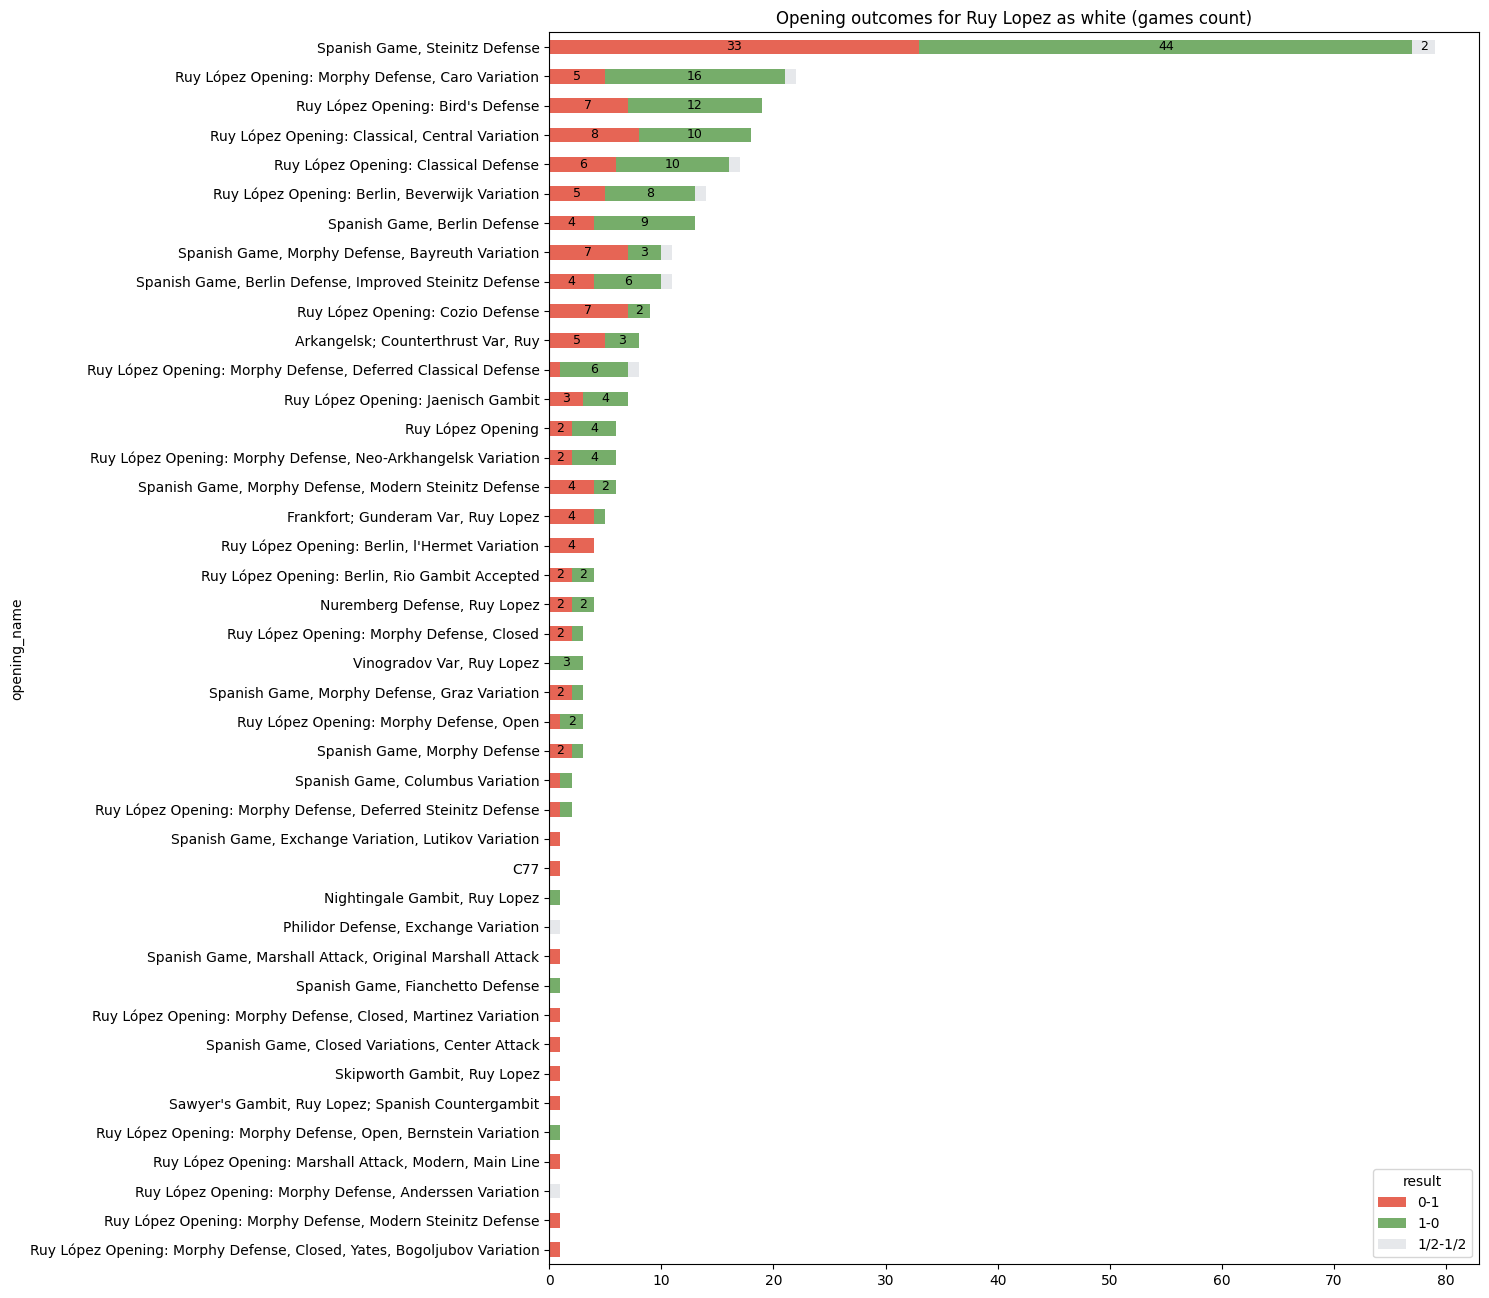

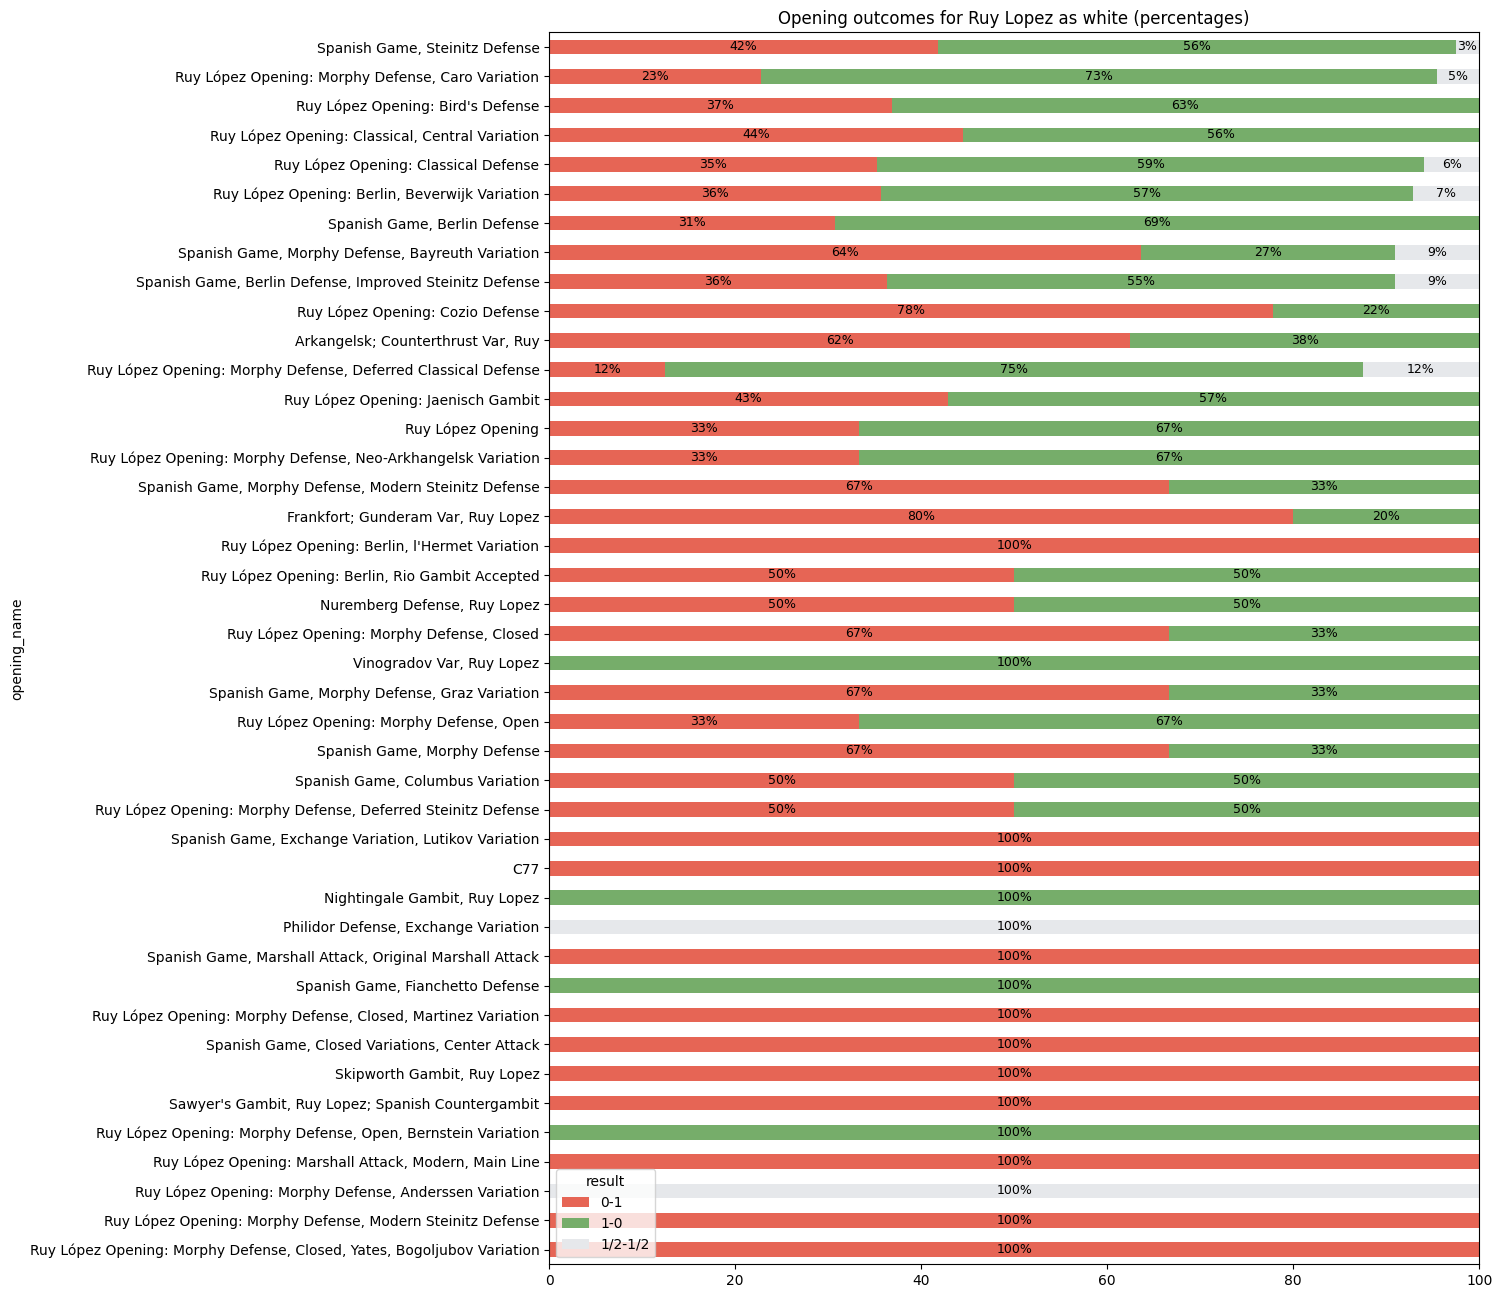

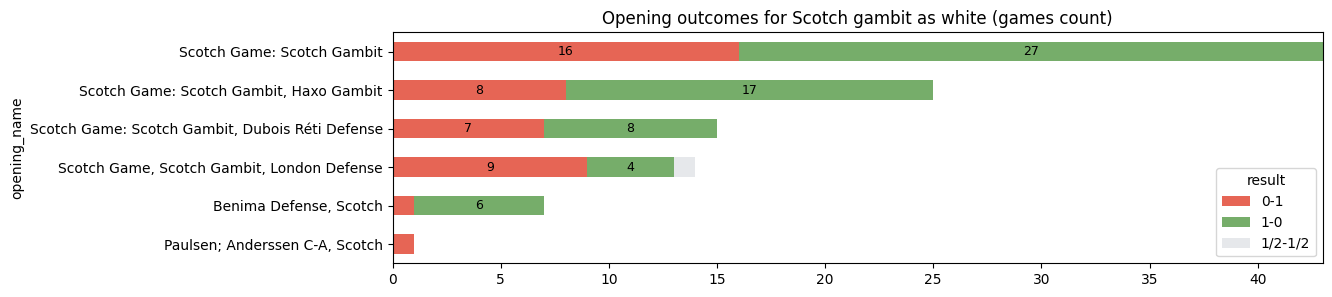

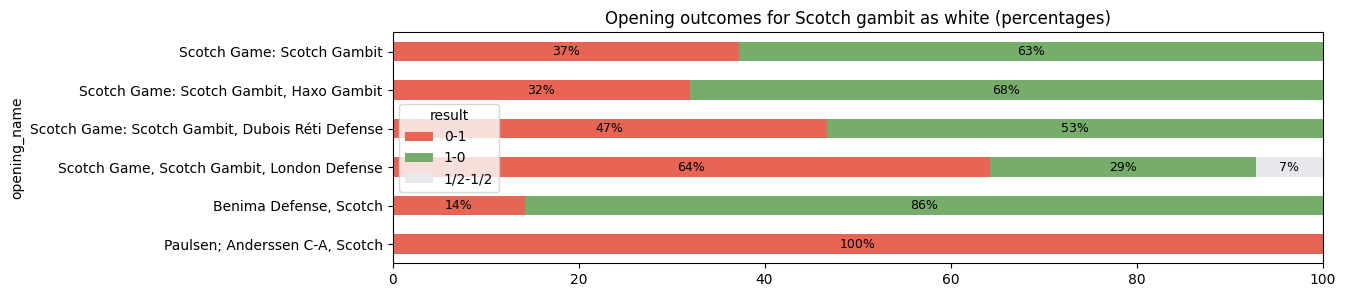

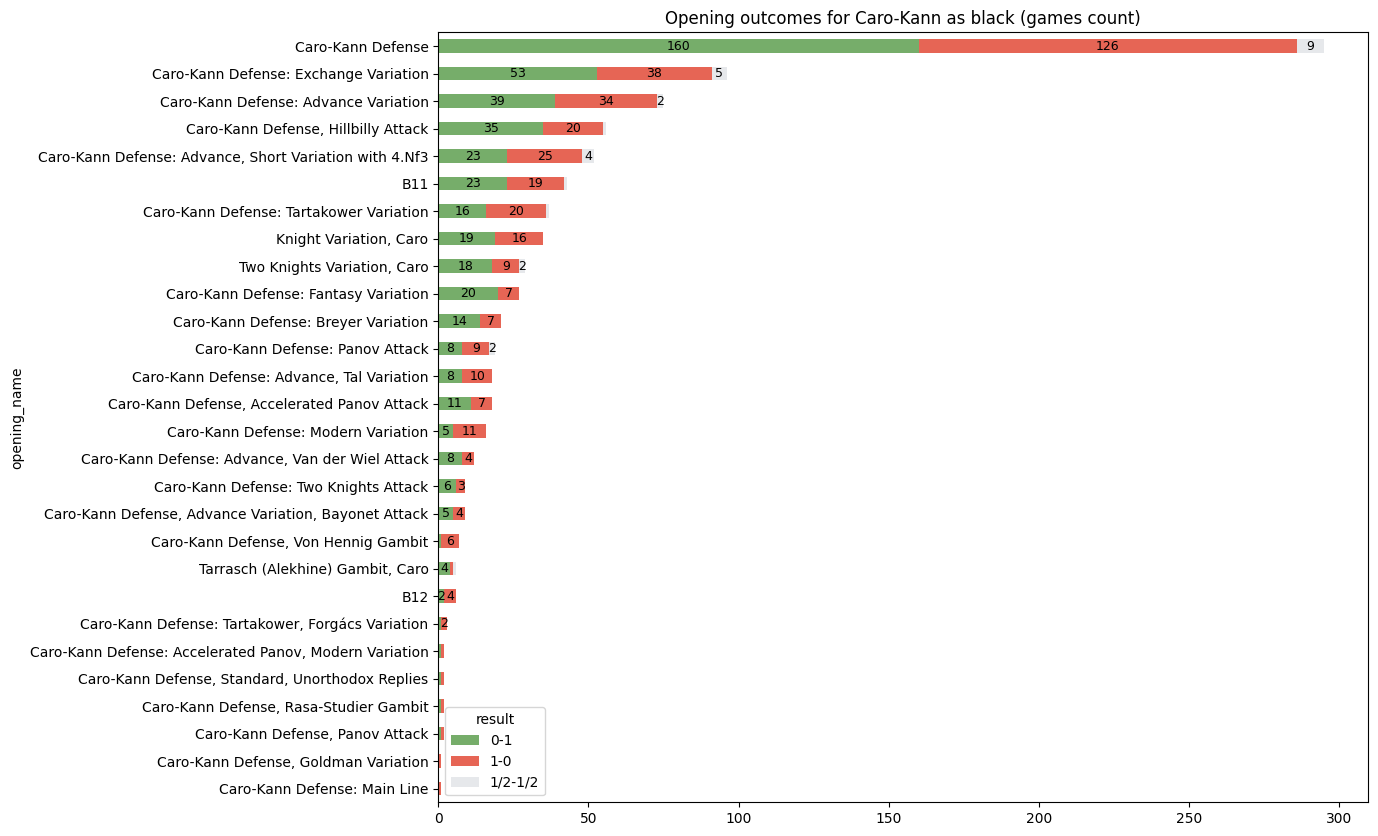

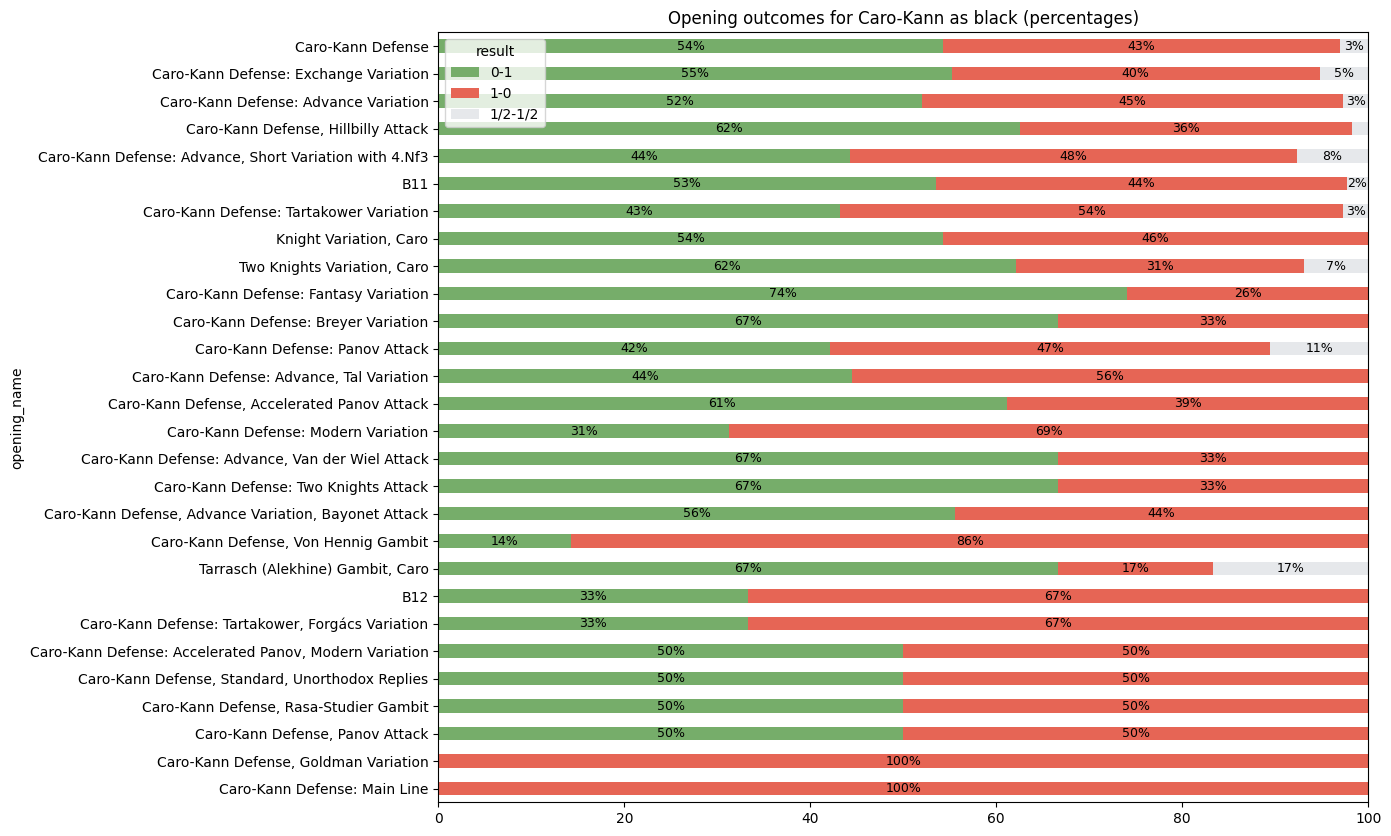

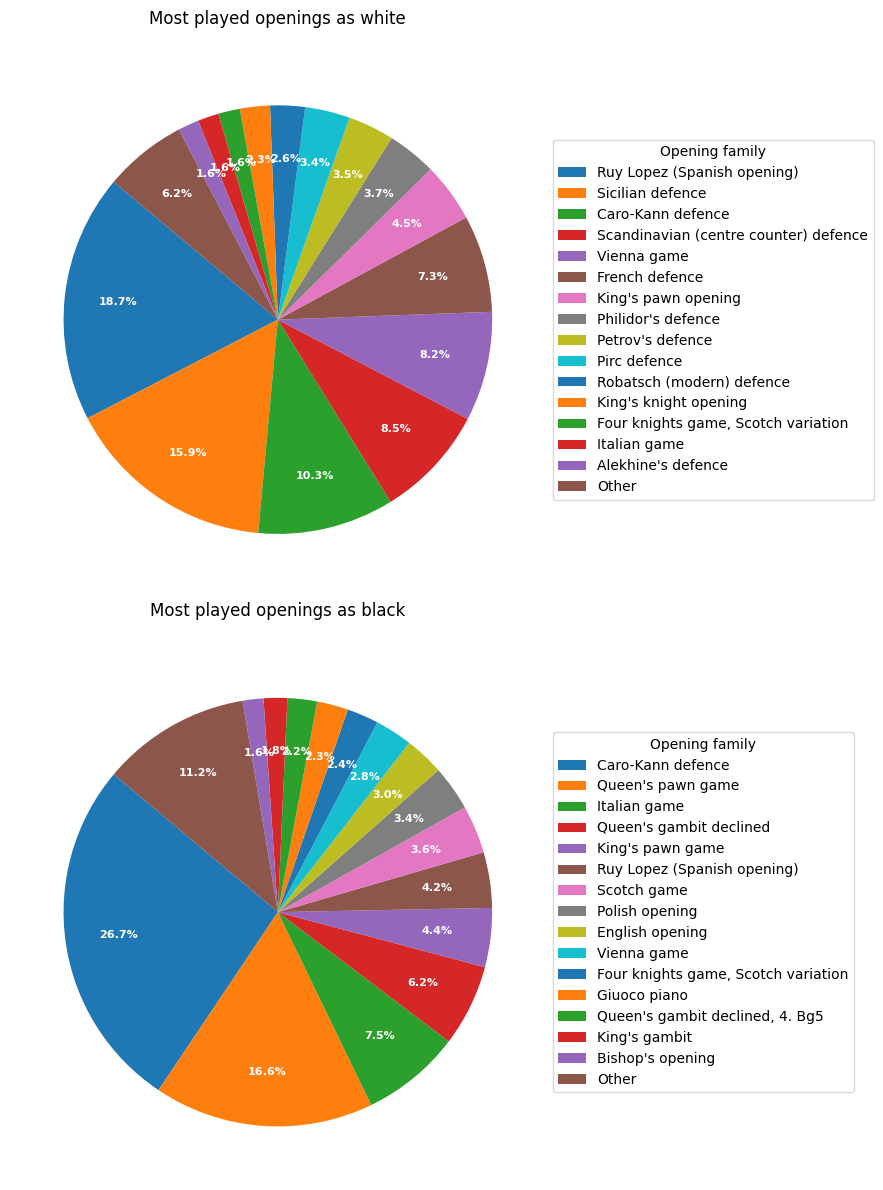

In [56]:
def plot_whole_game_analysis(games_with_openings, start_date, time_controls):
    plot_most_played_opening_families(games_with_openings)
    plot_ruy_lopez_as_white_deep_dive(games_with_openings, start_date, time_controls)
    plot_scotch_gambit_as_white_deep_dive(games_with_openings, start_date, time_controls)
    plot_caro_kann_as_black_deep_dive(games_with_openings, start_date, time_controls)

plot_whole_game_analysis(games_with_openings, start_date, relevant_time_controls)    

In [67]:
def old_opening_weakness_analysis(games):
    opening_outcomes = games[games["date"] >= "2025-01"][["date", "color", "result", "opening_family", "time_control"]]
    opening_outcomes = opening_outcomes[opening_outcomes['time_control'].isin(relevant_time_controls)]
    opening_outcomes_count = opening_outcomes.groupby(['color', 'opening_family', 'result']).size().reset_index(name='count')
    opening_family_totals = opening_outcomes_count.groupby(['color', 'opening_family'])['count'].transform('sum')
    
    opening_outcomes_count['percentage'] = (opening_outcomes_count['count'] / opening_family_totals) * 100
    opening_outcomes_count['games_count'] = opening_family_totals
    
    def convert_score_to_result(df, score_col = 'result', color_col = 'color'):
        conditions = [
            # 1. Win: (White and 1-0) OR (Black and 0-1)
            ((df[color_col] == 'White') & (df[score_col] == '1-0')) | 
            ((df[color_col] == 'Black') & (df[score_col] == '0-1')),
            
            # 2. Loss: (White and 0-1) OR (Black and 1-0)
            ((df[color_col] == 'White') & (df[score_col] == '0-1')) | 
            ((df[color_col] == 'Black') & (df[score_col] == '1-0')),
            
            # 3. Draw: 1/2-1/2 for either color
            (df[score_col] == '1/2-1/2')
        ]
        
        choices = ['Win', 'Loss', 'Draw']
        
        df['result'] = np.select(conditions, choices, default='Unknown')
        
        return df

    def identify_weak_openings(df):
        win_rate_map = df[df['result'] == 'Win'].set_index(['color', 'opening_family'])['percentage']
        df['opening_win_rate'] = df.set_index(['color', 'opening_family']).index.map(win_rate_map)
        
        loss_rate_map = df[df['result'] == 'Loss'].set_index(['color', 'opening_family'])['percentage']
        df['opening_loss_rate'] = df.set_index(['color', 'opening_family']).index.map(loss_rate_map)
        
        df_filtered = (
            df[df['opening_win_rate'] < df['opening_loss_rate']]
                .drop(columns=['opening_win_rate', 'opening_loss_rate'])
        )
        return df_filtered

    
    opening_outcomes_count = convert_score_to_result(opening_outcomes_count)
    opening_outcomes_count = opening_outcomes_count.sort_values(by=['games_count', 'opening_family', 'result'], ascending=False)
    weak_openings = identify_weak_openings(opening_outcomes_count)

    return weak_openings
